# tools for pre-processing images

In [1]:
%load_ext autoreload
%autoreload 2


In [3]:
__author__ = 'Pascal Louis <plouis35@gmail.com>'
__version__ = '0.2'
__keywords__ = ['astronomy', 'astropy', 'astroalign', 'ccdproc', 'matplotlib']


## configure display

In [4]:
### allow full width of browser
from IPython.display import display, HTML
display(HTML("<style>:root { --jp-notebook-max-width: 100% !important; }</style>"))

### matplotlib settings
import matplotlib.pyplot as plt

%config InlineBackend.rc = {}
plt.style.use(['dark_background'])
plt.rcParams.update({'figure.max_open_warning': 0}) 

### set the mpl backend
%matplotlib widget


## import libraries

In [5]:
import fnmatch, os
import numpy as np
from astropy import units as u
from astropy.nddata import CCDData
from ccdproc import ImageFileCollection, cosmicray_median, cosmicray_lacosmic, gain_correct
from convenience_functions import show_image
from easycombiner import Images


## define targets

In [28]:
TARGET = 'chcyg'
CAPTURE_DIR='../../../CAPTURES/OHP2024/20240710/'
BIAS_FILES = "Bias-*.fit"
DARK_FILES = "Dark-300s-*.fit"
FLAT_FILES = "flat-*.fit"
CALIB_FILES = "xenon_tcrb-5s-*.fit"
SCIENCE_FILES = "chcyg-30s-*.fit"
#TRIM_REGION = '0, 1300, 5496, 2000'              # x1, y1, x2, y2 
TRIM_REGION = None
EXPOSURE_KEY = 'EXPTIME'
camera_electronic_gain = 0.13 * u.electron/u.adu   # atik 420m 
camera_readout_noise = 3.0 * u.electron     # atik 420m


## define logger

In [22]:
### logger prints after every notebook cell
import sys
import logging

logging.basicConfig(
    format='%(asctime)s [%(levelname)s] - %(message)s',
    level=logging.INFO,
    datefmt='%Y-%m-%d %H:%M:%S',
    stream=sys.stdout,
)
logger = logging.getLogger('notebook')


## create masterbias

2024-07-23 20:31:12 [WARNING] - FITSFixedWarning: 'datfix' made the change 'Set MJD-OBS to 60175.400321 from DATE-OBS'.
2024-07-23 20:31:12 [INFO] - image : ../../../CAPTURES/OHP2024/20240710/Bias-1.fit loaded
2024-07-23 20:31:12 [WARNING] - FITSFixedWarning: 'datfix' made the change 'Set MJD-OBS to 60175.400362 from DATE-OBS'.
2024-07-23 20:31:12 [INFO] - image : ../../../CAPTURES/OHP2024/20240710/Bias-2.fit loaded
2024-07-23 20:31:12 [WARNING] - FITSFixedWarning: 'datfix' made the change 'Set MJD-OBS to 60175.400404 from DATE-OBS'.
2024-07-23 20:31:12 [INFO] - image : ../../../CAPTURES/OHP2024/20240710/Bias-3.fit loaded
2024-07-23 20:31:12 [WARNING] - FITSFixedWarning: 'datfix' made the change 'Set MJD-OBS to 60175.400445 from DATE-OBS'.
2024-07-23 20:31:12 [INFO] - image : ../../../CAPTURES/OHP2024/20240710/Bias-4.fit loaded


2024-07-23 20:31:12 [WARNING] - FITSFixedWarning: 'datfix' made the change 'Set MJD-OBS to 60175.400486 from DATE-OBS'.
2024-07-23 20:31:12 [INFO] - image : ../../../CAPTURES/OHP2024/20240710/Bias-5.fit loaded
2024-07-23 20:31:12 [WARNING] - FITSFixedWarning: 'datfix' made the change 'Set MJD-OBS to 60175.400527 from DATE-OBS'.
2024-07-23 20:31:12 [INFO] - image : ../../../CAPTURES/OHP2024/20240710/Bias-6.fit loaded
2024-07-23 20:31:12 [WARNING] - FITSFixedWarning: 'datfix' made the change 'Set MJD-OBS to 60175.400573 from DATE-OBS'.
2024-07-23 20:31:12 [INFO] - image : ../../../CAPTURES/OHP2024/20240710/Bias-7.fit loaded
2024-07-23 20:31:12 [WARNING] - FITSFixedWarning: 'datfix' made the change 'Set MJD-OBS to 60175.400616 from DATE-OBS'.
2024-07-23 20:31:12 [INFO] - image : ../../../CAPTURES/OHP2024/20240710/Bias-8.fit loaded


2024-07-23 20:31:12 [WARNING] - FITSFixedWarning: 'datfix' made the change 'Set MJD-OBS to 60175.400658 from DATE-OBS'.
2024-07-23 20:31:12 [INFO] - image : ../../../CAPTURES/OHP2024/20240710/Bias-9.fit loaded
2024-07-23 20:31:12 [INFO] - no trimming
2024-07-23 20:31:12 [INFO] - median combine on 9 images ...


2024-07-23 20:31:14 [INFO] - min=1188.0 adu, max=1323.0 adu, avg=1249.9584 adu
2024-07-23 20:31:14 [WARNING] - The following attributes were set on the data object, but will be ignored by the function: uncertainty, mask, meta, unit


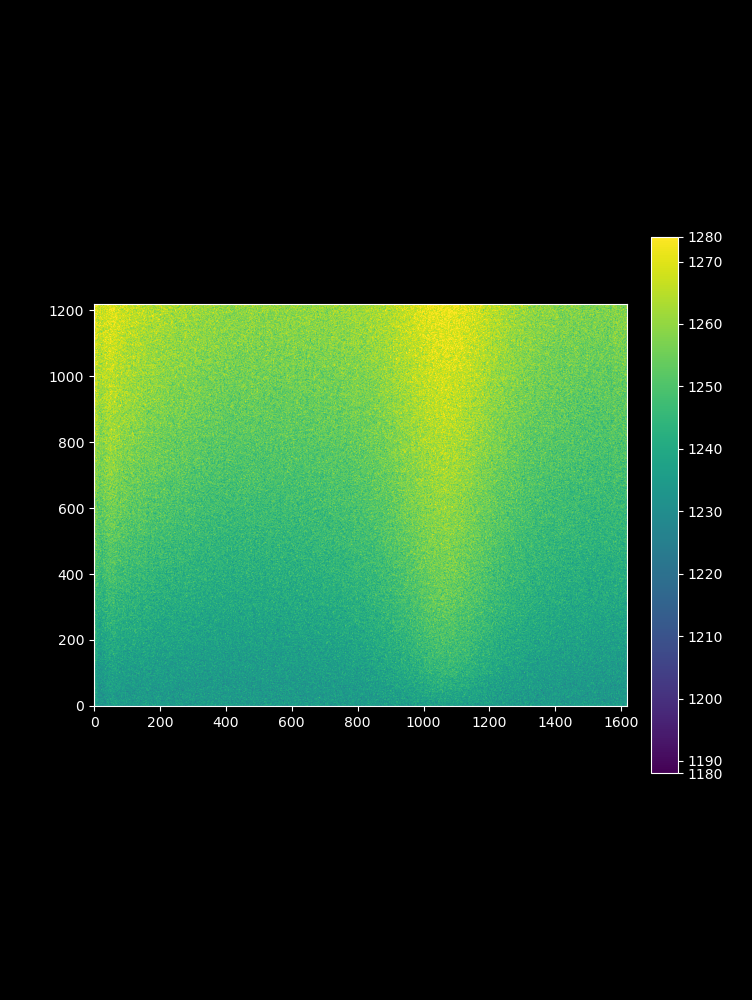

In [7]:
### create master bias
if (BIAS_FILES is not None): # and not (os.path.exists(CAPTURE_DIR + 'masterbias.fit')):
    master_bias = Images.from_fit(dir = CAPTURE_DIR, filter = BIAS_FILES, 
                                  camera_electronic_gain = camera_electronic_gain, camera_readout_noise = camera_readout_noise) \
                        .trim(TRIM_REGION) \
                        .median() 
                        #.sigmaclip() 
                        #.offset(1500 * u.adu) \
    master_bias.write(CAPTURE_DIR + 'masterbias.fit', overwrite=True) 
    logger.info(f'min={master_bias.min()}, max={master_bias.max()}, avg={master_bias.mean()}')
    show_image(image = master_bias, percl = 0, percu = 95)


## create masterdark

2024-07-23 20:31:15 [WARNING] - FITSFixedWarning: 'datfix' made the change 'Set MJD-OBS to 60175.443689 from DATE-OBS'.
2024-07-23 20:31:15 [INFO] - image : ../../../CAPTURES/OHP2024/20240710/Dark-300s-1.fit loaded
2024-07-23 20:31:15 [WARNING] - FITSFixedWarning: 'datfix' made the change 'Set MJD-OBS to 60175.447232 from DATE-OBS'.
2024-07-23 20:31:15 [INFO] - image : ../../../CAPTURES/OHP2024/20240710/Dark-300s-2.fit loaded
2024-07-23 20:31:15 [WARNING] - FITSFixedWarning: 'datfix' made the change 'Set MJD-OBS to 60175.450740 from DATE-OBS'.
2024-07-23 20:31:15 [INFO] - image : ../../../CAPTURES/OHP2024/20240710/Dark-300s-3.fit loaded
2024-07-23 20:31:15 [WARNING] - FITSFixedWarning: 'datfix' made the change 'Set MJD-OBS to 60175.454245 from DATE-OBS'.
2024-07-23 20:31:15 [INFO] - image : ../../../CAPTURES/OHP2024/20240710/Dark-300s-4.fit loaded


2024-07-23 20:31:15 [WARNING] - FITSFixedWarning: 'datfix' made the change 'Set MJD-OBS to 60175.457750 from DATE-OBS'.
2024-07-23 20:31:15 [INFO] - image : ../../../CAPTURES/OHP2024/20240710/Dark-300s-5.fit loaded
2024-07-23 20:31:15 [WARNING] - FITSFixedWarning: 'datfix' made the change 'Set MJD-OBS to 60175.461258 from DATE-OBS'.
2024-07-23 20:31:15 [INFO] - image : ../../../CAPTURES/OHP2024/20240710/Dark-300s-6.fit loaded
2024-07-23 20:31:15 [WARNING] - FITSFixedWarning: 'datfix' made the change 'Set MJD-OBS to 60175.464763 from DATE-OBS'.
2024-07-23 20:31:15 [INFO] - image : ../../../CAPTURES/OHP2024/20240710/Dark-300s-7.fit loaded
2024-07-23 20:31:15 [WARNING] - FITSFixedWarning: 'datfix' made the change 'Set MJD-OBS to 60175.468268 from DATE-OBS'.
2024-07-23 20:31:15 [INFO] - image : ../../../CAPTURES/OHP2024/20240710/Dark-300s-8.fit loaded
2024-07-23 20:31:15 [WARNING] - FITSFixedWarning: 'datfix' made the change 'Set MJD-OBS to 60175.471775 from DATE-OBS'.


2024-07-23 20:31:15 [INFO] - image : ../../../CAPTURES/OHP2024/20240710/Dark-300s-9.fit loaded
2024-07-23 20:31:15 [INFO] - no trimming
2024-07-23 20:31:16 [INFO] - masterbias substracted to 9 images
2024-07-23 20:31:16 [INFO] - median combine on 9 images ...
2024-07-23 20:31:18 [INFO] - min=-78.0 adu, max=64295.0 adu, avg=3.5958362 adu
2024-07-23 20:31:18 [WARNING] - The following attributes were set on the data object, but will be ignored by the function: uncertainty, mask, meta, unit


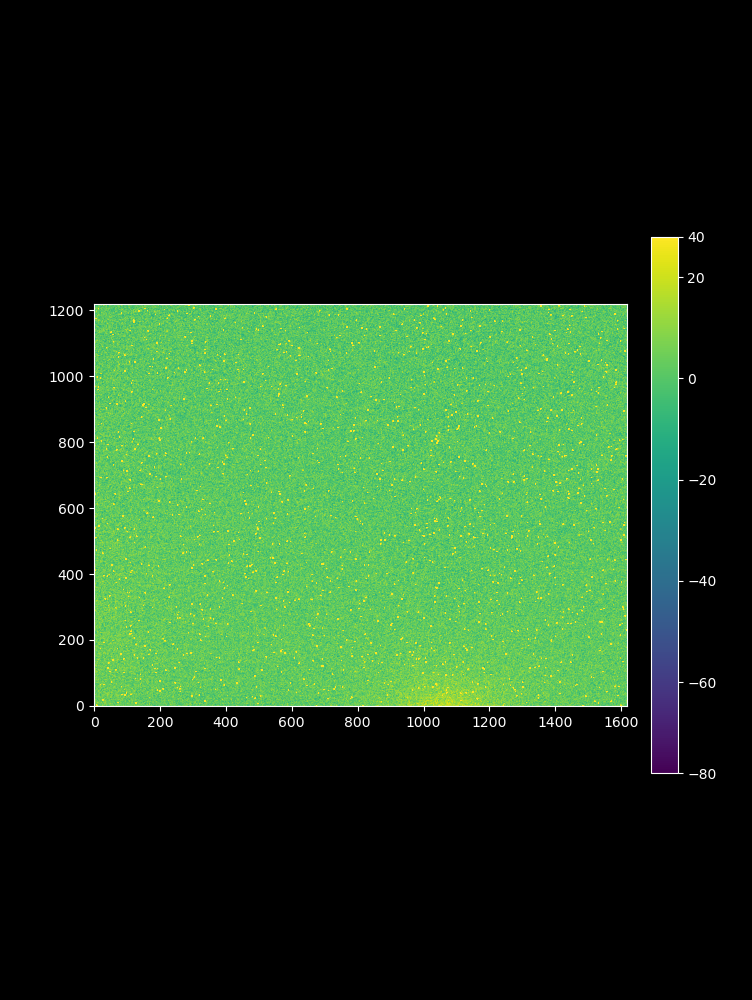

In [8]:
### create master dark
if (DARK_FILES is not None): # and not (os.path.exists(CAPTURE_DIR + 'masterdark.fit')):
    master_dark = Images.from_fit(dir = CAPTURE_DIR, filter = DARK_FILES, 
                                  camera_electronic_gain = camera_electronic_gain, camera_readout_noise = camera_readout_noise) \
                        .trim(TRIM_REGION) \
                        .bias_substract(master_bias) \
                        .median() 
                        #.sigmaclip() 
                        #.offset(1500 * u.adu) \
    master_dark.write(CAPTURE_DIR + 'masterdark.fit', overwrite=True) 
    logger.info(f'min={master_dark.min()}, max={master_dark.max()}, avg={master_dark.mean()}')
    show_image(image = master_dark, percl = 0, percu = 95)


## create masterflat

2024-07-23 20:31:18 [WARNING] - FITSFixedWarning: 'datfix' made the change 'Set MJD-OBS to 60237.722836 from DATE-OBS'.
2024-07-23 20:31:18 [INFO] - image : ../../../CAPTURES/OHP2024/20240710/flat-1.fit loaded
2024-07-23 20:31:18 [WARNING] - FITSFixedWarning: 'datfix' made the change 'Set MJD-OBS to 60237.722894 from DATE-OBS'.
2024-07-23 20:31:18 [INFO] - image : ../../../CAPTURES/OHP2024/20240710/flat-15.fit loaded
2024-07-23 20:31:18 [WARNING] - FITSFixedWarning: 'datfix' made the change 'Set MJD-OBS to 60237.722951 from DATE-OBS'.
2024-07-23 20:31:19 [INFO] - image : ../../../CAPTURES/OHP2024/20240710/flat-14.fit loaded


2024-07-23 20:31:19 [WARNING] - FITSFixedWarning: 'datfix' made the change 'Set MJD-OBS to 60237.723009 from DATE-OBS'.
2024-07-23 20:31:19 [INFO] - image : ../../../CAPTURES/OHP2024/20240710/flat-13.fit loaded
2024-07-23 20:31:19 [WARNING] - FITSFixedWarning: 'datfix' made the change 'Set MJD-OBS to 60237.723079 from DATE-OBS'.
2024-07-23 20:31:19 [INFO] - image : ../../../CAPTURES/OHP2024/20240710/flat-12.fit loaded
2024-07-23 20:31:19 [WARNING] - FITSFixedWarning: 'datfix' made the change 'Set MJD-OBS to 60237.723137 from DATE-OBS'.
2024-07-23 20:31:19 [INFO] - image : ../../../CAPTURES/OHP2024/20240710/flat-11.fit loaded
2024-07-23 20:31:19 [WARNING] - FITSFixedWarning: 'datfix' made the change 'Set MJD-OBS to 60237.723194 from DATE-OBS'.
2024-07-23 20:31:19 [INFO] - image : ../../../CAPTURES/OHP2024/20240710/flat-10.fit loaded
2024-07-23 20:31:19 [WARNING] - FITSFixedWarning: 'datfix' made the change 'Set MJD-OBS to 60237.723252 from DATE-OBS'.


2024-07-23 20:31:19 [INFO] - image : ../../../CAPTURES/OHP2024/20240710/flat-9.fit loaded
2024-07-23 20:31:19 [WARNING] - FITSFixedWarning: 'datfix' made the change 'Set MJD-OBS to 60237.723310 from DATE-OBS'.
2024-07-23 20:31:19 [INFO] - image : ../../../CAPTURES/OHP2024/20240710/flat-8.fit loaded
2024-07-23 20:31:19 [WARNING] - FITSFixedWarning: 'datfix' made the change 'Set MJD-OBS to 60237.723380 from DATE-OBS'.
2024-07-23 20:31:19 [INFO] - image : ../../../CAPTURES/OHP2024/20240710/flat-7.fit loaded
2024-07-23 20:31:19 [WARNING] - FITSFixedWarning: 'datfix' made the change 'Set MJD-OBS to 60237.723437 from DATE-OBS'.
2024-07-23 20:31:19 [INFO] - image : ../../../CAPTURES/OHP2024/20240710/flat-6.fit loaded
2024-07-23 20:31:19 [WARNING] - FITSFixedWarning: 'datfix' made the change 'Set MJD-OBS to 60237.723495 from DATE-OBS'.
2024-07-23 20:31:19 [INFO] - image : ../../../CAPTURES/OHP2024/20240710/flat-5.fit loaded
2024-07-23 20:31:19 [WARNING] - FITSFixedWarning: 'datfix' made the ch

2024-07-23 20:31:19 [INFO] - image : ../../../CAPTURES/OHP2024/20240710/flat-4.fit loaded
2024-07-23 20:31:19 [WARNING] - FITSFixedWarning: 'datfix' made the change 'Set MJD-OBS to 60237.723611 from DATE-OBS'.
2024-07-23 20:31:19 [INFO] - image : ../../../CAPTURES/OHP2024/20240710/flat-3.fit loaded
2024-07-23 20:31:19 [WARNING] - FITSFixedWarning: 'datfix' made the change 'Set MJD-OBS to 60237.723669 from DATE-OBS'.
2024-07-23 20:31:19 [INFO] - image : ../../../CAPTURES/OHP2024/20240710/flat-2.fit loaded
2024-07-23 20:31:19 [INFO] - no trimming


2024-07-23 20:31:20 [INFO] - masterbias substracted to 15 images
2024-07-23 20:31:20 [INFO] - sum combine on 15 images ...
INFO: splitting each image into 2 chunks to limit memory usage to 1000000000.0 bytes. [ccdproc.combiner]
2024-07-23 20:31:20 [INFO] - splitting each image into 2 chunks to limit memory usage to 1000000000.0 bytes.
2024-07-23 20:31:20 [INFO] - min=1095.0 adu, max=965160.0 adu, avg=374381.75 adu
2024-07-23 20:31:20 [WARNING] - The following attributes were set on the data object, but will be ignored by the function: uncertainty, mask, meta, unit


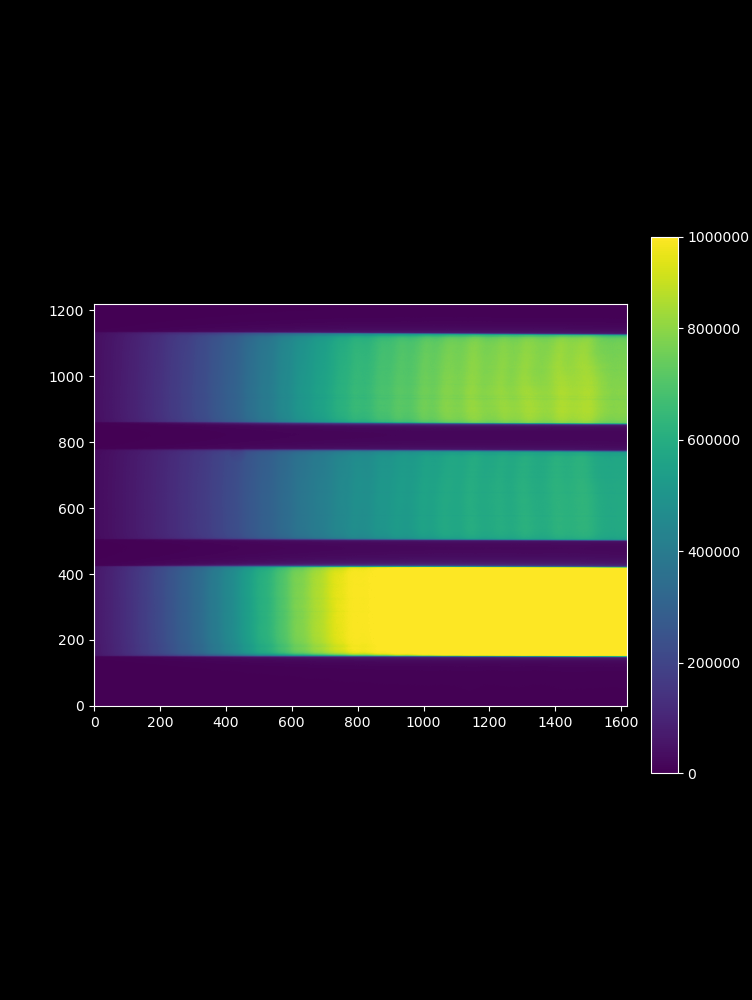

In [9]:
### create master flat
if (FLAT_FILES is not None): # and not (os.path.exists(CAPTURE_DIR + 'masterflat.fit')):
    master_flat = Images.from_fit(dir = CAPTURE_DIR, filter = FLAT_FILES, 
                                  camera_electronic_gain = camera_electronic_gain, camera_readout_noise = camera_readout_noise) \
                        .trim(TRIM_REGION) \
                        .bias_substract(master_bias) \
                        .sum()
#                        .median()
#                        .offset(1500 * u.adu) \
    master_flat.write(CAPTURE_DIR + 'masterflat.fit', overwrite=True) 
    logger.info(f'min={master_flat.min()}, max={master_flat.max()}, avg={master_flat.mean()}')
    show_image(image = master_flat, percl = 0, percu = 95)


## create mastercalib

2024-07-23 20:31:21 [WARNING] - FITSFixedWarning: 'datfix' made the change 'Set MJD-OBS to 60502.063239 from DATE-OBS'.
2024-07-23 20:31:21 [INFO] - image : ../../../CAPTURES/OHP2024/20240710/xenon_tcrb-5s-1.fit loaded
2024-07-23 20:31:21 [WARNING] - FITSFixedWarning: 'datfix' made the change 'Set MJD-OBS to 60502.063332 from DATE-OBS'.
2024-07-23 20:31:21 [INFO] - image : ../../../CAPTURES/OHP2024/20240710/xenon_tcrb-5s-2.fit loaded
2024-07-23 20:31:21 [WARNING] - FITSFixedWarning: 'datfix' made the change 'Set MJD-OBS to 60502.063425 from DATE-OBS'.
2024-07-23 20:31:21 [INFO] - image : ../../../CAPTURES/OHP2024/20240710/xenon_tcrb-5s-3.fit loaded
2024-07-23 20:31:21 [INFO] - no trimming


2024-07-23 20:31:21 [INFO] - masterbias substracted to 3 images
2024-07-23 20:31:21 [INFO] - median combine on 3 images ...
2024-07-23 20:31:22 [INFO] - min=-106.0 adu, max=10201.0 adu, avg=61.624332 adu
2024-07-23 20:31:22 [WARNING] - The following attributes were set on the data object, but will be ignored by the function: uncertainty, mask, meta, unit


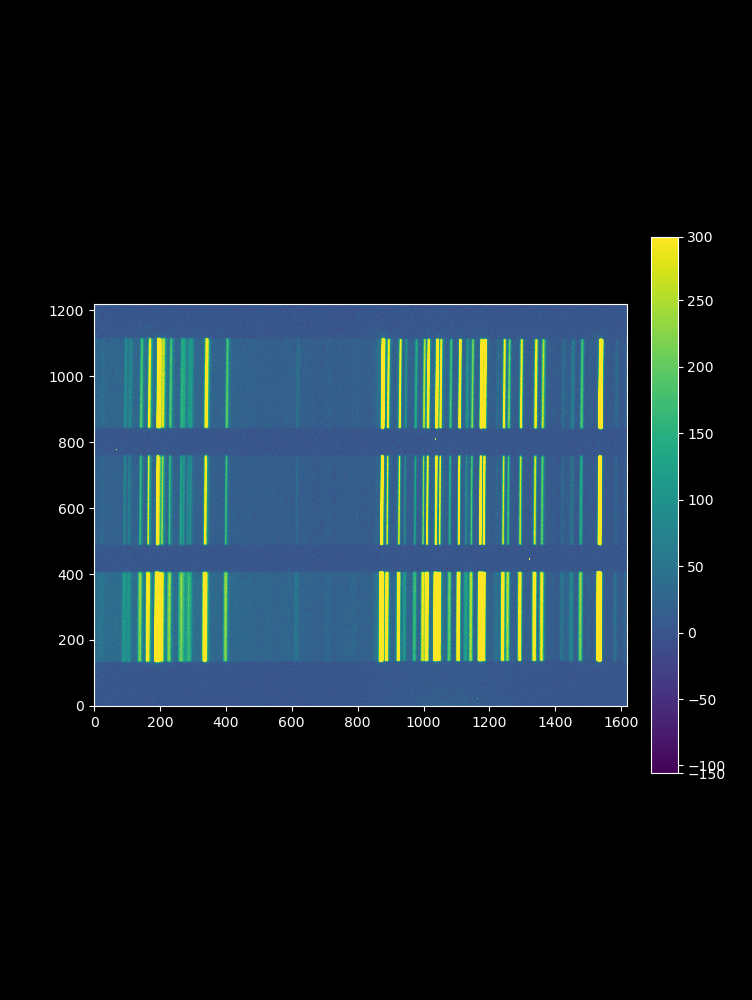

In [10]:
### create master calib
if (CALIB_FILES is not None): # and not (os.path.exists(CAPTURE_DIR + 'mastercalib.fit')):
    master_calib = Images.from_fit(dir = CAPTURE_DIR, filter = CALIB_FILES,
                                   camera_electronic_gain = camera_electronic_gain, camera_readout_noise = camera_readout_noise) \
                         .trim(TRIM_REGION) \
                         .bias_substract(master_bias) \
                         .median()
                         #.sigmaclip()
#                         .offset(1500 * u.adu) \
    master_calib.write(CAPTURE_DIR + 'mastercalib.fit', overwrite=True) 
    logger.info(f'min={master_calib.min()}, max={master_calib.max()}, avg={master_calib.mean()}')
    show_image(image = master_calib, percl = 0, percu = 95)


## reduce science frames

2024-07-25 21:36:28 [INFO] - read refernce frames...
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
2024-07-25 21:36:28 [INFO] - using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
2024-07-25 21:36:28 [WARNING] - FITSFixedWarning: 'datfix' made the change 'Set MJD-OBS to 60175.400321 from DATE-OBS'.
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
2024-07-25 21:36:28 [INFO] - using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
2024-07-25 21:36:28 [WARNING] - FITSFixedWarning: 'datfix' made the change 'Set MJD-OBS to 60175.443689 from DATE-OBS'.
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
2024-07-25 21:36:28 [INFO] - using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
2024-

2024-07-25 21:36:28 [WARNING] - FITSFixedWarning: 'datfix' made the change 'Set MJD-OBS to 60501.892003 from DATE-OBS'.
2024-07-25 21:36:28 [INFO] - image : ../../../CAPTURES/OHP2024/20240710/chcyg-30s-2.fit loaded
2024-07-25 21:36:28 [WARNING] - FITSFixedWarning: 'datfix' made the change 'Set MJD-OBS to 60501.892385 from DATE-OBS'.
2024-07-25 21:36:28 [INFO] - image : ../../../CAPTURES/OHP2024/20240710/chcyg-30s-3.fit loaded
2024-07-25 21:36:28 [WARNING] - FITSFixedWarning: 'datfix' made the change 'Set MJD-OBS to 60501.892768 from DATE-OBS'.
2024-07-25 21:36:28 [INFO] - image : ../../../CAPTURES/OHP2024/20240710/chcyg-30s-4.fit loaded
2024-07-25 21:36:28 [WARNING] - FITSFixedWarning: 'datfix' made the change 'Set MJD-OBS to 60501.893151 from DATE-OBS'.


2024-07-25 21:36:28 [INFO] - image : ../../../CAPTURES/OHP2024/20240710/chcyg-30s-5.fit loaded
2024-07-25 21:36:28 [INFO] - no trimming
2024-07-25 21:36:29 [INFO] - 5 images reduced
2024-07-25 21:36:29 [INFO] - align: fftconvolve running...
2024-07-25 21:36:30 [INFO] - align: get max cross-correlation for every image...
2024-07-25 21:36:30 [INFO] - align: images deltas = [(0, 0), (0, 0), (0, 0), (0, 0)]
2024-07-25 21:36:30 [INFO] - align: images realignement ...
2024-07-25 21:36:30 [INFO] - align: complete
2024-07-25 21:36:31 [INFO] - frame 0: min=-42243.785 adu, max=580104.5 adu, avg=57.254505 adu
2024-07-25 21:36:31 [INFO] - frame 1: min=-43227.535 adu, max=580104.5 adu, avg=49.992462 adu
2024-07-25 21:36:31 [INFO] - frame 2: min=-47228.11 adu, max=580104.5 adu, avg=49.35836 adu
2024-07-25 21:36:31 [INFO] - frame 3: min=-44801.53 adu, max=580104.5 adu, avg=39.034435 adu
2024-07-25 21:36:31 [INFO] - frame 4: min=-41178.06 adu, max=580104.5 adu, avg=52.26383 adu
2024-07-25 21:36:31 [IN

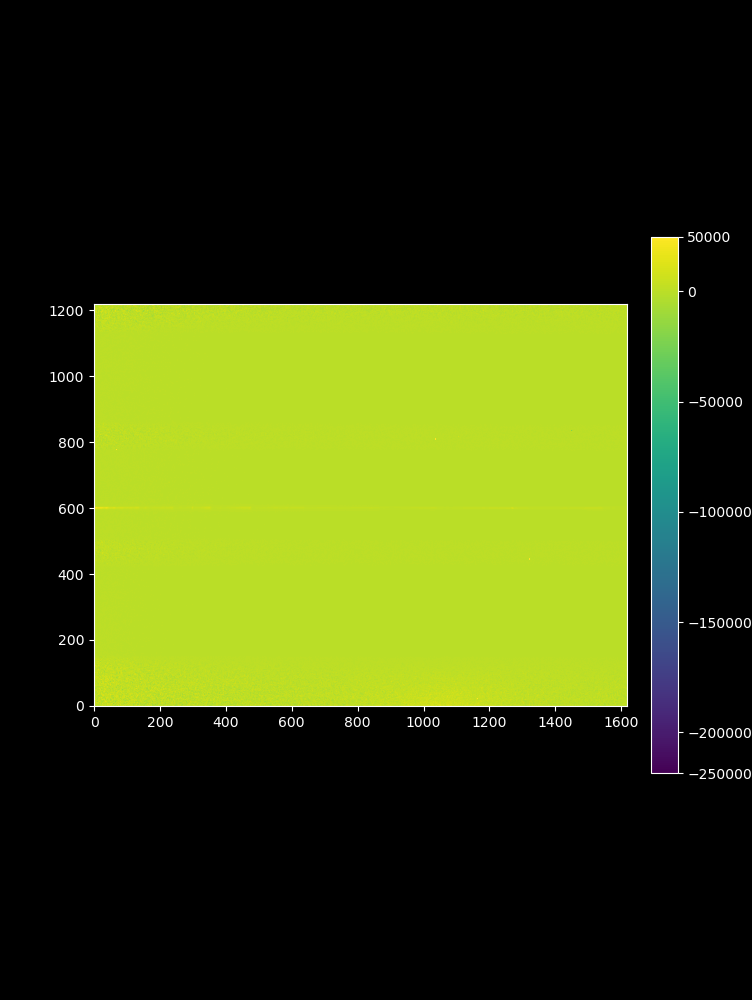

In [29]:
### read master reference frames
logger.info('read refernce frames...')

master_bias = CCDData.read(CAPTURE_DIR + 'masterbias.fit', unit = u.adu)
master_dark = CCDData.read(CAPTURE_DIR + 'masterdark.fit', unit = u.adu)
master_flat = CCDData.read(CAPTURE_DIR + 'masterflat.fit', unit = u.adu)

### reduce science frames
master_sciences = Images.from_fit(dir = CAPTURE_DIR, filter = SCIENCE_FILES, 
                                  camera_electronic_gain = camera_electronic_gain, camera_readout_noise = camera_readout_noise) \
                        .trim(TRIM_REGION) \
                        .reduce(master_bias = master_bias, master_dark = master_dark, master_flat = master_flat, exposure_key = EXPOSURE_KEY) \
                        .spec_align(ref_image_index = 0)                        # fft based - best for spectra fields

#                        .star_align(ref_image_index = 0)                        # astro_align (triangles) based - best for stars fields
#                        .bias_substract(master_bias) \
#                        .dark_substract(master_dark, scale_exposure = True, exposure = EXPOSURE_KEY) \
#                        .flat_divide(master_flat) \
#                        .offset(1500 * u.adu) \

### optional: save individual frames
for i, frame in zip(range(0, len(master_sciences)), master_sciences):
    frame.write(f'{CAPTURE_DIR}{TARGET}-{i}-reduced.fit', overwrite=True)
    logger.info(f'frame {i}: min={frame.min()}, max={frame.max()}, avg={frame.mean()}')

### combine frames (sum or median) & save master science frame
master_science = master_sciences.sum() 
#master_science = master_sciences.median()

### update fits header
master_science.meta['EXPTIME2'] = f'{len(master_sciences)} x {master_science.meta[EXPOSURE_KEY]} s'
master_science.meta['EXPTIME'] = len(master_sciences) * master_science.meta[EXPOSURE_KEY]

master_science.write(f'{CAPTURE_DIR}{TARGET}-reduced.fit', overwrite=True)
logger.info(f'master_science: min={master_science.min()}, max={master_science.max()}, avg={master_science.mean()}')
show_image(image = master_science, percl = 0, percu = 99.9)


## remove cosmics

2024-07-25 21:36:36 [INFO] - master_science: min=-218679.03 adu, max=2900522.5 adu, avg=247.90346 adu
2024-07-25 21:36:36 [INFO] - gain_corrected: min=-28428.273 electron, max=377067.9 electron, avg=32.227463 electron


/Users/papa/miniforge3/lib/python3.11/site-packages/ccdproc/core.py:1762: RuntimeWarning: divide by zero encountered in divide
  rarr = (data - marr) / error_image


2024-07-25 21:36:38 [INFO] - master_science_clean: min=-10713.306 electron, max=7641.8647 electron, avg=32.64183 electron


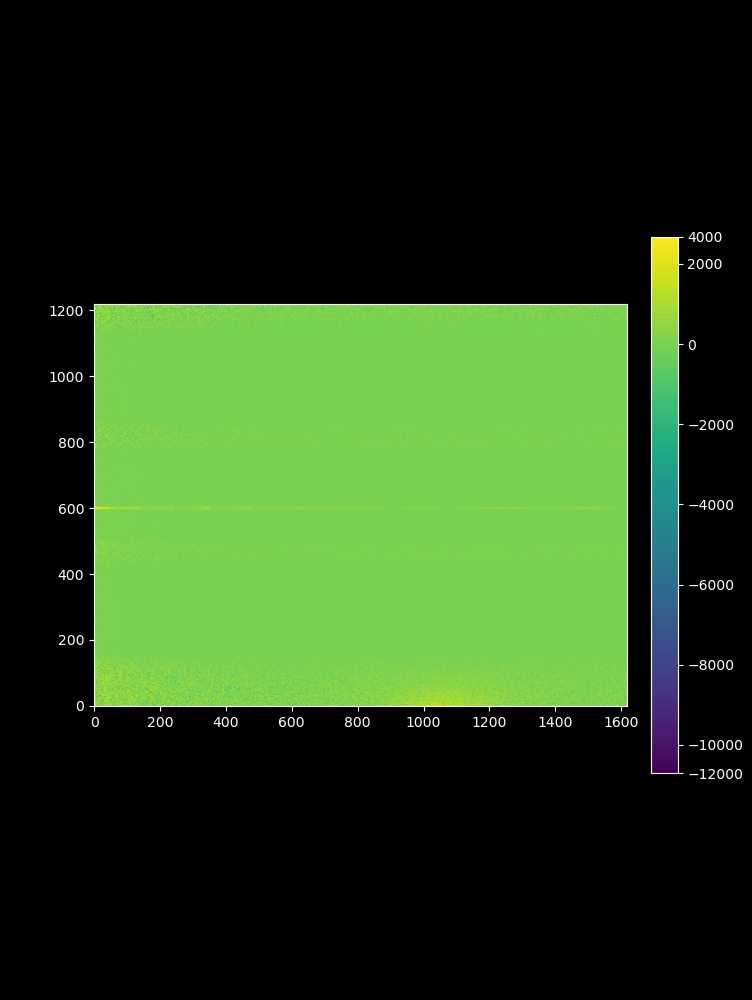

In [30]:
from astropy.convolution import convolve, Gaussian2DKernel, Tophat2DKernel
from astropy.modeling.models import Gaussian2D
from astropy.convolution import Box2DKernel

logger.info(f'master_science: min={master_science.min()}, max={master_science.max()}, avg={master_science.mean()}')

gain_corrected = gain_correct(master_science, camera_electronic_gain)
logger.info(f'gain_corrected: min={gain_corrected.min()}, max={gain_corrected.max()}, avg={gain_corrected.mean()}')

"""
master_science_clean = cosmicray_lacosmic(gain_corrected,
                                          #satlevel = 1e7,
                                          #niter = 1,
                                          gain_apply = False,
                                          sigclip = 15,
                                          cleantype = 'median',
                                          fsmode = 'median',
                                          verbose = True
                                         )
"""
#cosmicray_median(sci_master, thresh = 3, mbox=3, rbox=5, gbox=3, error_image = np.ones(sci_master.shape))
#sci_cleaned = cosmicray_median(sci_master, thresh = 3, mbox=3, rbox=5, gbox=3, error_image = np.ones(sci_master.shape))
master_science_clean = cosmicray_median(gain_corrected, #gain_corrected,
                                        thresh = 3,
                                        mbox = 3,
                                        rbox = 5, 
                                        gbox = 3,
#                                        error_image = np.ones(gain_corrected.shape)
                                       )


#tophat_kernel = Box2DKernel(5)
#master_science_clean = convolve(gain_corrected, tophat_kernel)

#master_science_clean = CCDData(CCDData.add(master_science_clean, 1000 * u.electron))
                                
#print(master_science_clean.unit)
logger.info(f'master_science_clean: min={master_science_clean.min()}, max={master_science_clean.max()}, avg={master_science_clean.mean()}')
master_science_clean.write(f'{CAPTURE_DIR}{TARGET}-reduced-cosmics.fit', overwrite=True)
show_image(image = master_science_clean, percl = 0, percu = 99.9)


In [13]:
import numpy as np
logger.info(f'master_science avg uncertainty : {master_science.uncertainty.array.mean()}')
logger.info(f'master_science clean avg uncertainty : {master_science_clean.uncertainty.array.mean()}')


2024-07-23 20:31:26 [INFO] - master_science avg uncertainty : 1143.025390625
2024-07-23 20:31:26 [INFO] - master_science clean avg uncertainty : 148.59326171875
